In [125]:
import os
import random
import pyreadr
import itertools as it

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, TimeDistributed, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.callbacks import EarlyStopping
import tensorflow as tf

import dues_utilities as utils
import matplotlib.pyplot as plt

from IPython.display import display
import importlib
importlib.reload(utils)

<module 'dues_utilities' from 'C:\\Users\\benchoi\\Projects\\dues\\ml\\dues_utilities.py'>

In [126]:
# Number of timesteps before 't' model uses in each prediction step
timesteps = 24

# Additional Parameters
add_context = True # whether all sim or just relevant sim data is given at each prediciton step
num_targets = 29 # number of buildings
verbose = 0 # controls verbosity of output during training
N = 5 # number of times to repreat each experiment (and average results across)

# Define queries for each fold
folds = utils.get_folds(3)

# Callback Functions
callbacks = []
callbacks.append(EarlyStopping(patience=2))

In [127]:
# Read data formatted by R scripts

PATH_ENERGY_BASELINE = "../data/all/building_energy_retrofit_baseline.csv"
PATH_ENERGY_ACTUAL_STATIONARY = "../data/building_energy_actual_stationary.csv"

energy_dtype = {
    'apn': str, 
    'year': np.float32, 
    'month': np.float32, 
    'day': np.float32, 
    'hour': np.float32, 
    'kwh': np.float32
}

energy_retrofit_baseline = pd.read_csv(PATH_ENERGY_BASELINE, dtype=energy_dtype)
energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL_STATIONARY, dtype=energy_dtype)

# Combined simulation and observed data into properly formatted dataframe
energy = utils.get_energy_df(
        energy_retrofit_baseline, 
        energy_actual, 
        one_hot=False, 
        temporal_scale='hour', 
        spatial_scale='building',
        add_context=add_context
    )

Retrieving DUE-S Energy Data...


## Supervised Experiments

In [ ]:
# Query for train, val, test split
train_folds, val_folds, test_folds = utils.make_supervised_folds(folds, energy, timesteps, None)
n_features = train_folds[0][0].shape[-1]

### Linear Regression

In [ ]:
lr_model = LinearRegression()

metrics = utils.walk_forward_cv(lr_model, train_folds, val_folds, test_folds, simple=True)

utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 189.93959824244183
# MSE: 9141.97998046875
# CV(RMSE): 55.47295276815662
# MBE: -2.020330448945363

# Overall Test:
# MAPE: 189.31085268656415
# MSE: 8597.76416015625
# CV(RMSE): 54.17478953866275
# MBE: -1.8855419158935547

### KNN

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=1)

metrics = utils.walk_forward_cv(knn_model, train_folds, val_folds, test_folds, simple=True)

utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 36.308494955301285
# MSE: 7894.553466796875
# CV(RMSE): 50.844112055883855
# MBE: 15.018418371677399

# Overall Test:
# MAPE: 35.82461327314377
# MSE: 5369.8382568359375
# CV(RMSE): 42.84330763067136
# MBE: 4.418466746807098

### ANN

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(8, activation='relu', input_shape = [n_features]))
ann_model.add(Dense(1))

metrics = utils.repeat_experiment(
        ann_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="ANN"
    )
utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 38.00202697515488
# MSE: 43097.4432800293
# CV(RMSE): 117.60132177260635
# MBE: -69.48708001375198

# Overall Test:
# MAPE: 40.03982916474342
# MSE: 42431.93391723634
# CV(RMSE): 117.8805092994159
# MBE: -70.02141468524933

#### Reshaping for Models with 3D Input



In [ ]:
for idx, fold in enumerate(train_folds):
    train_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(train_folds[idx][0][:, :-num_targets], timesteps, df_name="Train"),
                np.repeat(train_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        train_folds[idx][1]
    )
    val_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(val_folds[idx][0][:, :-num_targets], timesteps, df_name="Val"),
                np.repeat(val_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        val_folds[idx][1]
    )
    test_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(test_folds[idx][0][:, :-num_targets], timesteps, df_name="Test"),
                np.repeat(test_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        test_folds[idx][1]
    )

n_features = train_folds[0][0].shape[-1]

### Vanilla LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(8, input_shape = (timesteps, n_features)))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))

metrics = utils.repeat_experiment(
        lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Vanilla LSTM"
    )
utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 50.77106049284339
# MSE: 9434.811126708984
# CV(RMSE): 54.157817864135325
# MBE: -14.903981592878699

# Overall Test:
# MAPE: 42.56542481482029
# MSE: 8869.950701904296
# CV(RMSE): 54.161317168255835
# MBE: -20.77920241802931

### CNN

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(8, kernel_size=2, input_shape = (timesteps, n_features)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1))

metrics = utils.repeat_experiment(
        cnn_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="CNN"
    )
utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 39.318471290171146
# MSE: 8778.81907043457
# CV(RMSE): 54.12282267014075
# MBE: -17.353715103864673

# Overall Test:
# MAPE: 41.622185446321964
# MSE: 8367.039208984375
# CV(RMSE): 53.45222762279509
# MBE: -20.648522400856017

## Sequence Experiments

In [128]:
train_folds, val_folds, test_folds = utils.make_seq_folds(folds, energy, timesteps, scalers=None)

n_features = train_folds[0][0].shape[-1]
    
val_agg_ref = []
test_agg_ref = []

for idx, fold in enumerate(folds):
    val_agg_ref.append(utils.equalize_timesteps(energy, fold[1], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    val_agg_ref[idx]['kwh_actual'] = val_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
    test_agg_ref.append(utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    test_agg_ref[idx]['kwh_actual'] = test_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

Processing Fold #1...
Train: (5220, 24, 58) (5220, 24, 1)
Val: (5307, 24, 58) (5307, 24, 1)
Test: (5220, 24, 58) (5220, 24, 1)
Processing Fold #2...
Train: (10556, 24, 58) (10556, 24, 1)
Val: (5220, 24, 58) (5220, 24, 1)
Test: (5307, 24, 58) (5307, 24, 1)
Processing Fold #3...
Train: (15805, 24, 58) (15805, 24, 1)
Val: (5307, 24, 58) (5307, 24, 1)
Test: (10556, 24, 58) (10556, 24, 1)


### Vanilla LSTM

-----Experiment #1-----

Fold #1
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 24, 64)            31488     
_________________________________________________________________
lstm_28 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 24, 1)             33        
Total params: 66,625
Trainable params: 66,625
Non-trainable params: 0
_________________________________________________________________


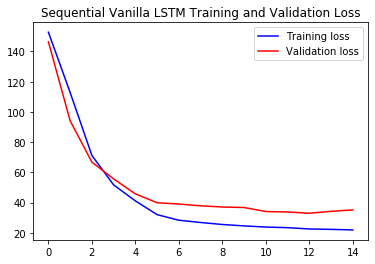


Fold #2


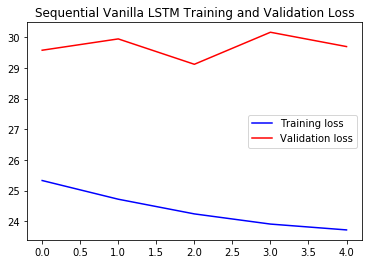


Fold #3


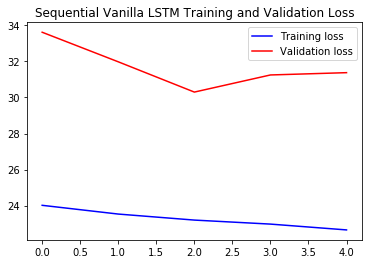

[[[2.71497945e+01 5.74380373e+03 4.29350471e+01 1.15941694e+01]
  [1.80542138e+01 9.67189776e+05 2.32114589e+01 2.78277020e+02]
  [1.24742187e+01 3.17521936e+08 1.37916256e+01 8.48584948e+03]]

 [[1.45049164e+01 9.84478832e+05 1.94004898e+01 3.35924970e+02]
  [8.79248569e+00 1.91288283e+08 1.12583467e+01 8.06851259e+03]
  [6.60745094e+00 6.65899229e+10 6.88707561e+00 2.46089647e+05]]]
[[[2.47749866e+01 4.00815378e+03 3.70487189e+01 5.88995341e+00]
  [1.58404990e+01 7.34429601e+05 2.09020715e+01 1.41399524e+02]
  [1.04358833e+01 1.84025464e+08 1.09118318e+01 4.28749358e+03]]

 [[1.15778814e+01 6.64013349e+05 1.64528035e+01 1.70710944e+02]
  [7.39651524e+00 1.41080331e+08 9.99341860e+00 4.09903215e+03]
  [3.57634190e+00 2.98240614e+10 4.79009469e+00 1.24337347e+05]]]


In [33]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
lstm_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential Vanilla LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

lstm_model.save('../models/vanilla_lstm')

# [[[2.70699094e+01 5.94538557e+03 4.36655861e+01 1.09915102e+01]
#   [1.82871612e+01 1.00725315e+06 2.36574766e+01 2.63819469e+02]
#   [1.28130898e+01 3.62897269e+08 1.45943604e+01 8.04497766e+03]]

#  [[1.51734541e+01 1.03924719e+06 1.99026962e+01 3.18463757e+02]
#   [9.56325743e+00 1.96959581e+08 1.13838323e+01 7.64932280e+03]
#   [6.71363328e+00 7.36764836e+10 7.04605350e+00 2.33304355e+05]]]
# [[[2.43970489e+01 4.06543261e+03 3.73011638e+01 6.71941133e+00]
#   [1.55426042e+01 7.33877747e+05 2.08806397e+01 1.61427563e+02]
#   [1.04572114e+01 1.97968293e+08 1.11942207e+01 4.89478051e+03]]

#  [[1.17808916e+01 6.82809360e+05 1.66679977e+01 1.94751464e+02]
#   [7.51242057e+00 1.37589253e+08 9.84826583e+00 4.67962548e+03]
#   [3.94896550e+00 3.04913292e+10 4.52066212e+00 1.41948643e+05]]]

In [129]:
energy = utils.get_energy_df(
        energy_retrofit_baseline, 
        energy_actual, 
        one_hot=False, 
        temporal_scale='hour', 
        spatial_scale='building', 
        add_context=False
    )

train_folds, val_folds, test_folds = utils.make_seq_folds(folds, energy, timesteps, scalers=None)

n_features = train_folds[0][0].shape[-1]
    
val_agg_ref = []
test_agg_ref = []

for idx, fold in enumerate(folds):
    val_agg_ref.append(utils.equalize_timesteps(energy, fold[1], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    val_agg_ref[idx]['kwh_actual'] = val_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
    test_agg_ref.append(utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    test_agg_ref[idx]['kwh_actual'] = test_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (5220, 24, 30) (5220, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (5220, 24, 30) (5220, 24, 1)
Processing Fold #2...
Train: (10556, 24, 30) (10556, 24, 1)
Val: (5220, 24, 30) (5220, 24, 1)
Test: (5307, 24, 30) (5307, 24, 1)
Processing Fold #3...
Train: (15805, 24, 30) (15805, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (10556, 24, 30) (10556, 24, 1)


-----Experiment #1-----

Fold #1
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 24, 64)            24320     
_________________________________________________________________
lstm_38 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_37 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_38 (TimeDis (None, 24, 1)             33        
Total params: 59,457
Trainable params: 59,457
Non-trainable params: 0
_________________________________________________________________


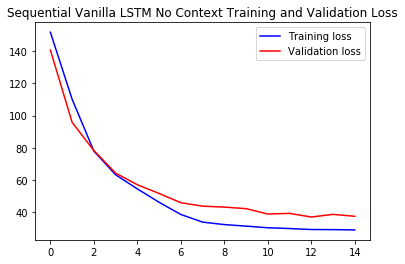


Fold #2


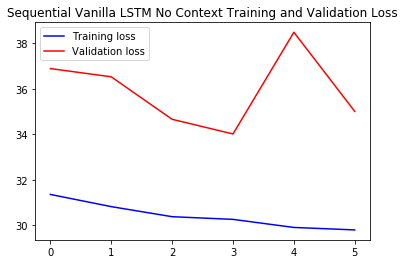


Fold #3


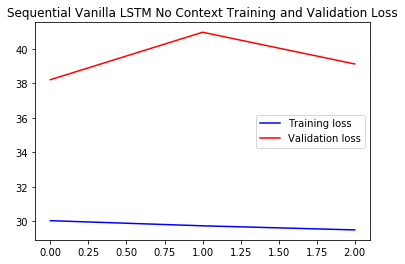

[[[ 3.15790652e+01  8.21825898e+03  5.13572854e+01 -1.00349660e+00]
  [ 2.37024904e+01  1.69488705e+06  3.07267743e+01 -2.41216663e+01]
  [ 1.76697567e+01  6.51371903e+08  1.97534566e+01 -7.35572353e+02]]

 [[ 1.79103089e+01  1.58543988e+06  2.46197927e+01 -2.90749211e+01]
  [ 1.41692284e+01  4.12297364e+08  1.65285864e+01 -6.99396396e+02]
  [ 1.07261264e+01  1.68334900e+11  1.09500897e+01 -2.13315614e+04]]]
[[[2.83491283e+01 5.96635596e+03 4.52017852e+01 1.41538302e+00]
  [1.93345405e+01 1.20959292e+06 2.68246374e+01 3.42998343e+01]
  [1.21005295e+01 3.21925900e+08 1.44323371e+01 1.04003400e+03]]

 [[1.47476249e+01 1.11849116e+06 2.13534367e+01 4.10226303e+01]
  [1.16625592e+01 2.73341536e+08 1.39102091e+01 9.94318224e+02]
  [5.87590961e+00 6.32628160e+10 6.97645771e+00 3.01609718e+04]]]


In [69]:
# No Context Experiments

lstm_no_context_model = Sequential()
lstm_no_context_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=True))
lstm_no_context_model.add(LSTM(64, return_sequences=True))
lstm_no_context_model.add(TimeDistributed(Dense(32, activation='relu')))
lstm_no_context_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        lstm_no_context_model, 1,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential Vanilla LSTM No Context",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

lstm_no_context_model.save('../models/vanilla_lstm_no_context')

# [[[ 3.10289856e+01  8.26818146e+03  5.15097535e+01 -9.93994830e-01]
#   [ 2.29311274e+01  1.64847035e+06  3.02981613e+01 -2.38873706e+01]
#   [ 1.68836613e+01  6.24632760e+08  1.93288333e+01 -7.28427642e+02]]

#  [[ 1.82609651e+01  1.61418903e+06  2.48405408e+01 -2.87996218e+01]
#   [ 1.37825840e+01  3.92967399e+08  1.61328762e+01 -6.92603329e+02]
#   [ 1.03677019e+01  1.57943352e+11  1.05982225e+01 -2.11244114e+04]]]
# [[[2.79069522e+01 6.00400645e+03 4.53414355e+01 1.07741521e+00]
#   [1.83892914e+01 1.15745724e+06 2.62358556e+01 2.61092548e+01]
#   [1.12813244e+01 2.89692196e+08 1.36583354e+01 7.91680707e+02]]

#  [[1.49857047e+01 1.13378501e+06 2.14969556e+01 3.12271683e+01]
#   [1.13801228e+01 2.58797352e+08 1.35337353e+01 7.56881454e+02]
#   [5.53267824e+00 5.72362823e+10 6.62598773e+00 2.29587468e+04]]]

### Seq2Seq LSTM

In [ ]:
lstm_autoencoder_model = Sequential()
lstm_autoencoder_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=False))
lstm_autoencoder_model.add(RepeatVector(timesteps))
lstm_autoencoder_model.add(LSTM(64, return_sequences=True))
lstm_autoencoder_model.add(TimeDistributed(Dense(32, activation='relu')))
lstm_autoencoder_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        lstm_autoencoder_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential Seq2Seq LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

### CNN-LSTM

In [ ]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, activation='relu', kernel_size=2, input_shape=(timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(RepeatVector(timesteps))
cnn_lstm_model.add(LSTM(64, return_sequences=True))
cnn_lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
cnn_lstm_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        cnn_lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential CNN-LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

## Retrofit Experiments

In [130]:
rerun_analysis = False
lstm_model = load_model('../models/vanilla_lstm')
lstm_no_context_model = load_model('../models/vanilla_lstm_no_context')

model = lstm_no_context_model
add_context = False

PATH_RETROFIT_ROOT = "../data/all/"
PATH_RETROFIT_OUTPUT = "../data/test.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_all_mae.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_block_mae.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_old_mae.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_all_mae_no_context.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_block_mae_no_context.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_old_mae_no_context.csv"

In [221]:
PATH_ENERGY_FULL = PATH_RETROFIT_ROOT + "building_energy_retrofit_full.csv"
PATH_ENERGY_LIGHT = PATH_RETROFIT_ROOT + "building_energy_retrofit_light.csv"
PATH_ENERGY_WINDOW = PATH_RETROFIT_ROOT + "building_energy_retrofit_window.csv"

PATH_FULL_SAVINGS_HISTORY = '../savings_analysis/full_savings.csv'
PATH_LIGHT_SAVINGS_HISTORY = '../savings_analysis/light_savings.csv'
PATH_WINDOW_SAVINGS_HISTORY = '../savings_analysis/window_savings.csv'

PATH_FULL_NO_CONTEXT_SAVINGS_HISTORY = '../savings_analysis/full_savings_no_context.csv'
PATH_LIGHT_NO_CONTEXT_SAVINGS_HISTORY = '../savings_analysis/light_savings_no_context.csv'
PATH_WINDOW_NO_CONTEXT_SAVINGS_HISTORY = '../savings_analysis/window_savings_no_context.csv'

energy_retrofit_full = pd.read_csv(PATH_ENERGY_FULL, dtype=energy_dtype)
energy_retrofit_light = pd.read_csv(PATH_ENERGY_LIGHT, dtype=energy_dtype)
energy_retrofit_window = pd.read_csv(PATH_ENERGY_WINDOW, dtype=energy_dtype)

energy_retrofits = utils.equalize_timesteps(energy, folds[-1][-1], timesteps, one_hot=False)
energy_retrofits = energy_retrofits.filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual'])
energy_retrofits['kwh_actual'] = energy_retrofits['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

scalers = utils.make_seq_folds(folds, energy, timesteps, scalers=None, get_scalers=True)

energy_full = utils.get_energy_df(energy_retrofit_full, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building', add_context=add_context)
full_train_folds, full_val_folds, full_test_folds = utils.make_seq_folds(folds, energy_full, timesteps, scalers)

energy_light = utils.get_energy_df(energy_retrofit_light, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building', add_context=add_context)
light_train_folds, light_val_folds, light_test_folds = utils.make_seq_folds(folds, energy_light, timesteps, scalers)

energy_window = utils.get_energy_df(energy_retrofit_window, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building', add_context=add_context)
window_train_folds, window_val_folds, window_test_folds = utils.make_seq_folds(folds, energy_window, timesteps, scalers)

energy_retrofits['kwh_baseline'] = model.predict(test_folds[-1][0]).ravel()
energy_retrofits['kwh_full'] = model.predict(full_test_folds[-1][0]).ravel()
energy_retrofits['kwh_light'] = model.predict(light_test_folds[-1][0]).ravel()
energy_retrofits['kwh_window'] = model.predict(window_test_folds[-1][0]).ravel()

energy_retrofits.to_csv(PATH_RETROFIT_OUTPUT, index=False)

In [75]:
# savings = []

# # All buildings retrofitted
# print("All buildings retrofitted: " + str(utils.calc_savings(model, energy, energy_full, folds, num_rows, target_one_hot, scalers[-1], timesteps, all_columns, baseline_energy)))

# if rerun_analysis:
#     subsets = set()
#     for k in range(4):
#         subsets.update(set(it.combinations(all_columns, k)))
#     for subset in subsets:
#         saving = utils.calc_savings(model, energy, energy_full, folds, num_rows, target_one_hot, scalers[-1], timesteps, subset, baseline_energy)
#         savings.append(saving)

#     with open('../savings_analysis/savings_up_to_3.npy', 'wb') as f:
#         np.save(f, savings)
        
# with open('../savings_analysis/savings_up_to_3.npy', 'rb') as f:
#     savings = np.load(f)
    
# plt.hist(savings)
# plt.show()

Full, No Context: 
0    00600970130000
1    00603700370000
2    00601020190000
3    00601530150000
4    00601450250000
5    00601020200000
Name: building, dtype: object

Full, With Context: 
0    00600470120000
1    00603700370000
2    00601010030000
3    00601040010000
4    00601450250000
5    00601530150000
6    00601030110000
Name: building, dtype: object

Cumulative % Change Up to Elbow, No Context:-2.0396947860717773
Cumulative % Change Up to Elbow, With Context:-12.450146675109863


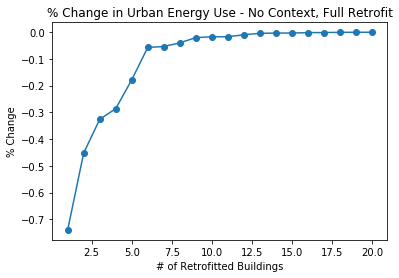

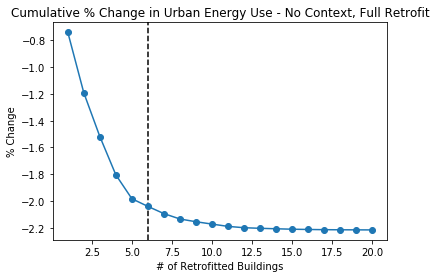

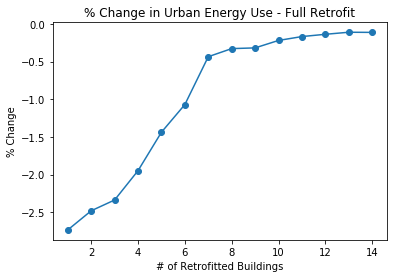

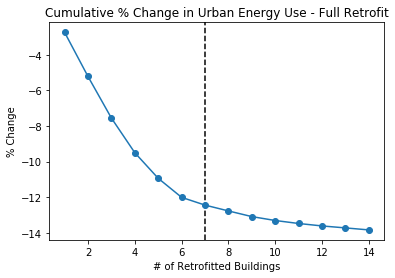

In [273]:
if rerun_analysis:
    utils.stepwise_selection_no_context(energy_retrofits, 'kwh_full', PATH_FULL_NO_CONTEXT_SAVINGS_HISTORY)
    utils.stepwise_selection(model, energy, energy_full, folds, test_folds, scalers[-1], timesteps, PATH_FULL_SAVINGS_HISTORY)

full_stepwise_history_no_context = pd.read_csv(PATH_FULL_SAVINGS_NO_CONTEXT_HISTORY)
full_stepwise_history = pd.read_csv(PATH_FULL_SAVINGS_HISTORY)

NO_CONTEXT_ELBOW = 6
ELBOW = 7
importlib.reload(utils)
no_context_sum = np.sum(full_stepwise_history_no_context['savings'][:NO_CONTEXT_ELBOW])
context_sum = np.sum(full_stepwise_history['savings'][:ELBOW])

print("Full, No Context: ")
print(full_stepwise_history_no_context[:NO_CONTEXT_ELBOW]['building'].str.lstrip('kwh_sim_'))
print("\nFull, With Context: ")
print(full_stepwise_history[:ELBOW]['building'].str.lstrip('kwh_sim_'))

print("\nCumulative % Change Up to Elbow, No Context:" + str(no_context_sum))
print("Cumulative % Change Up to Elbow, With Context:" + str(context_sum))

utils.plot_stepwise_history(full_stepwise_history_no_context, NO_CONTEXT_ELBOW, "No Context, Full")
utils.plot_stepwise_history(full_stepwise_history, ELBOW, "Full")

Light, No Context: 
0    00603700370000
1    00601450250000
2    00601020190000
3    00601060050000
4    00600970130000
5    00601530150000
6    00600470120000
Name: building, dtype: object

Light, With Context: 
0    00601040010000
1    00600470120000
2    00603700370000
3    00601450250000
4    00600910010000
Name: building, dtype: object

Cumulative % Change Up to Elbow, No Context:-0.13251900672912598
Cumulative % Change Up to Elbow, With Context:-2.419513463973999


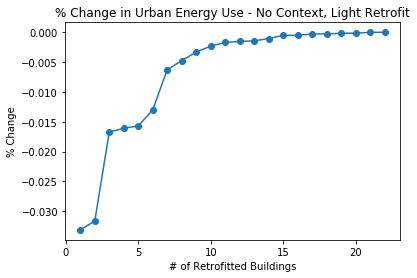

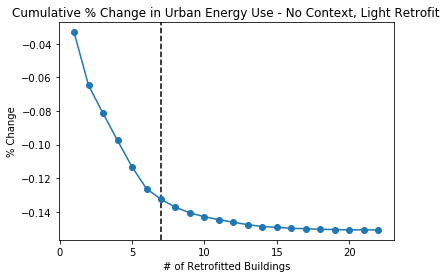

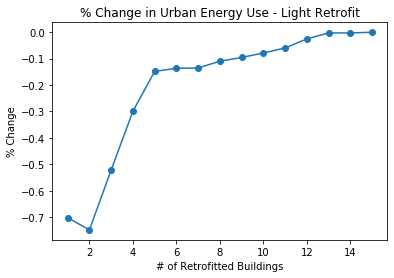

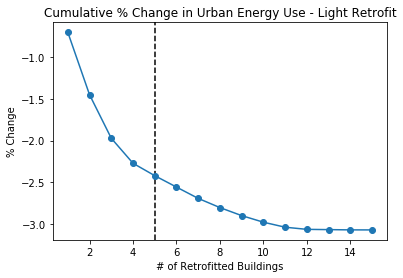

In [274]:
if rerun_analysis:
    utils.stepwise_selection_no_context(energy_retrofits, 'kwh_light', PATH_LIGHT_NO_CONTEXT_SAVINGS_HISTORY)
    utils.stepwise_selection(model, energy, energy_light, folds, test_folds, scalers[-1], timesteps, PATH_LIGHT_SAVINGS_HISTORY)

light_stepwise_history_no_context = pd.read_csv(PATH_LIGHT_SAVINGS_NO_CONTEXT_HISTORY)
light_stepwise_history = pd.read_csv(PATH_LIGHT_SAVINGS_HISTORY)

NO_CONTEXT_ELBOW = 7
ELBOW = 5

no_context_sum = np.sum(light_stepwise_history_no_context['savings'][:NO_CONTEXT_ELBOW])
context_sum = np.sum(light_stepwise_history['savings'][:ELBOW])

print("Light, No Context: ")
print(light_stepwise_history_no_context[:NO_CONTEXT_ELBOW]['building'].str.lstrip('kwh_sim_'))
print("\nLight, With Context: ")
print(light_stepwise_history[:ELBOW]['building'].str.lstrip('kwh_sim_'))

print("\nCumulative % Change Up to Elbow, No Context:" + str(no_context_sum))
print("Cumulative % Change Up to Elbow, With Context:" + str(context_sum))

utils.plot_stepwise_history(light_stepwise_history_no_context, NO_CONTEXT_ELBOW, "No Context, Light")
utils.plot_stepwise_history(light_stepwise_history, ELBOW, "Light")

Window, No Context: 
0    00600970130000
1    00603700370000
2    00601020190000
3    00601530150000
4    00601450250000
5    00601020200000
Name: building, dtype: object

Window, With Context: 
0    00601010030000
1    00600470120000
2    00603700370000
3    00601040010000
4    00601450250000
5    00601530150000
6    00600970150000
Name: building, dtype: object

Cumulative % Change Up to Elbow, No Context:-1.9255518913269043
Cumulative % Change Up to Elbow, With Context:-9.355968236923218


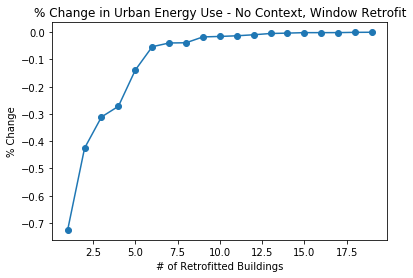

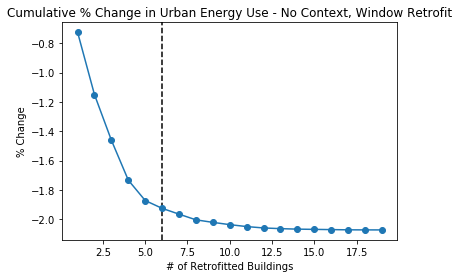

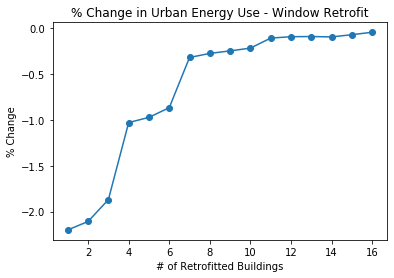

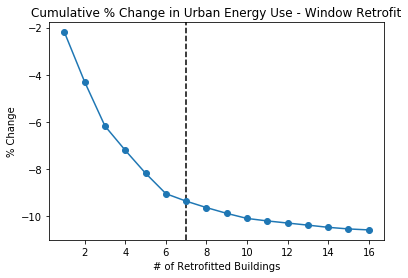

In [275]:
if rerun_analysis:
    utils.stepwise_selection_no_context(energy_retrofits, 'kwh_window', PATH_WINDOW_NO_CONTEXT_SAVINGS_HISTORY)
    utils.stepwise_selection(model, energy, energy_window, folds, test_folds, scalers[-1], timesteps, PATH_WINDOW_SAVINGS_HISTORY)

window_stepwise_history_no_context = pd.read_csv(PATH_WINDOW_SAVINGS_NO_CONTEXT_HISTORY)
window_stepwise_history = pd.read_csv(PATH_WINDOW_SAVINGS_HISTORY)

NO_CONTEXT_ELBOW = 6
ELBOW = 7

no_context_sum = np.sum(window_stepwise_history_no_context['savings'][:NO_CONTEXT_ELBOW])
context_sum = np.sum(window_stepwise_history['savings'][:ELBOW])

print("Window, No Context: ")
print(window_stepwise_history_no_context[:NO_CONTEXT_ELBOW]['building'].str.lstrip('kwh_sim_'))
print("\nWindow, With Context: ")
print(window_stepwise_history[:ELBOW]['building'].str.lstrip('kwh_sim_'))

print("\nCumulative % Change Up to Elbow, No Context:" + str(no_context_sum))
print("Cumulative % Change Up to Elbow, With Context:" + str(context_sum))

utils.plot_stepwise_history(window_stepwise_history_no_context, NO_CONTEXT_ELBOW, "No Context, Window")
utils.plot_stepwise_history(window_stepwise_history, ELBOW, "Window")

In [276]:
# Todos:

# [X] Investigate exploding gradients, using clip values for gradient clipping
# [X] Visualize per building error distribution
# [X] Implement additional benchmarks (e.g. SVR?)
# [X] Multiple temporal and spatial scale analysis
# [X] See what happens with retrofits
# [ ] Experiment with subsetting to optimize for cumulative urban-scale reductions in energy/CO2 consumption
# [ ] Investigate domain transfer techniques
# [ ] Investigate visualization strategies for LSTM and Conv Layers